In [ ]:
# imports
import numpy as np
from matplotlib import pyplot as plt

Formula for:

-> Fourier components: 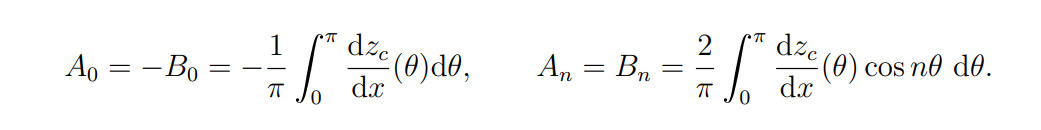

-> Camber derivative function:

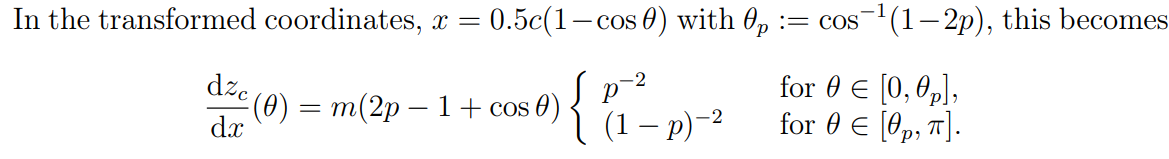

-> Contribution of fourier components in camber:

Integrating 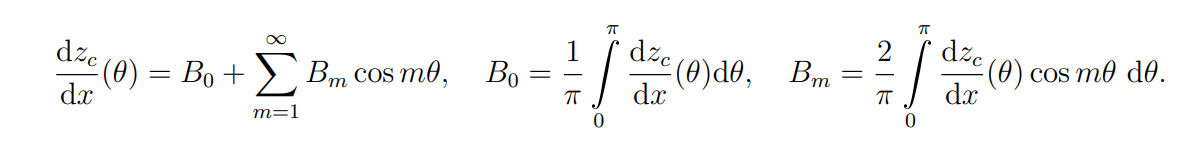

-> Circulation density at θ, γ(θ) due to camber:

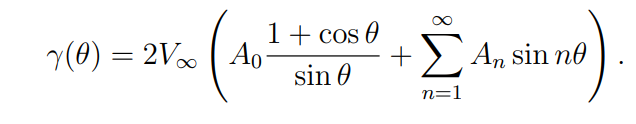

-> Circulation density at θ, γ(θ) due to angle of attack:

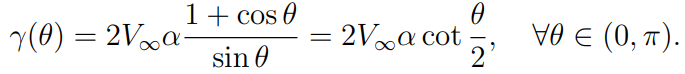

-> cl, cm(c/4):

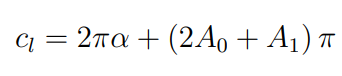

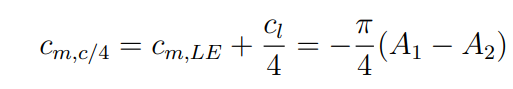

-> Velocity at some point x,y due to vortex sheet with varying circulation density, γ(s):

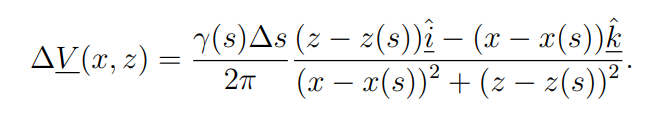

In [ ]:
"""-> Integration wherever needed is done as numerical integration; area under
the curve method where rectangles of some small width and length as the
value of function (getting integrated) at that point, ∑ (f(θ))dθ.
-> Most of the formulas used throughout the program are described at the start in text box"""
vinfi = 1
chord = 1  # whole program is written assuming chord length and free stream velocity to be 1 to get non-dimensionalized feel of variables

# defining class for NACA 4-digit airfoil parameters calculations
class airfoil(object):
    # showing the outputs
    def __init__(self):
      # basic parameters
      self.str_foil = input("Which NACA 4-digit airfoil you want to study: ")
      self.m = int(self.str_foil[0])/100   # extracting camber from airfoil name
      self.p = int(self.str_foil[1])/10    # extracting location of max. camber from airfoil name
      mthck = (int(self.str_foil[2])*10 + int(self.str_foil[3]))/100  # finding max. thickness of airfoil
      # checking if input airfoil is a valid NACA 4-digit airfoil
      if len(self.str_foil) == 4 and self.m == 0 and self.p == 0: # checks if given airfoil is symmetric, so run only following commands
        self.alfa = float(input("At what angle of attack (in degrees): ")) # getting input for angle of attack
        self.nPts = float(input("How many points you want to divide vortex sheet into (eg: 100): "))
        self.nSrs = 0
        self.An = [0]
        self.zclist = [0]   # as the fucntion to draw the streamlines is same class, these variable are called there but does not make
        self.thta = [0]     # much sense for symmetric airfoil, therefore, setting them to zero
        self.litzcx = [0]
        self.zcx = [0]
        print("\n")
        print(self.str_foil + " is a symmetric NACA 4-digit airfoil")
        self.symmairfoil()
      elif len(self.str_foil) == 4 and self.m != 0 and self.p != 0: # checks if given airfoil is cambered, , so run the following commands
        self.alfa = float(input("At what angle of attack (in degrees): ")) # getting input for angle of attack
        self.nPts = float(input("How many points you want to divide vortex sheet into (eg: 100): "))
        self.nSrs = int(input("How many Fourier components you want to compare (eg: 10): ")) # how many fourier coefficients user want to study
        print("\n")
        dthta = np.pi/self.nPts # change in theta value in transformed axis, for division of vortex sheet and also used for integration purposes
        print(self.str_foil + " is a cambered NACA 4-digit airfoil")
        self.thetap = np.arccos(1-2*self.p) # location of maximum camber in theta axis, which is θp = cos-1(1-2p)
        self.fouriercomp()                  # calling all the function to calculate the results
        self.vortsheet()                    # for cambered airfoil, calling needed functions (explained later)
        self.fouriercambcontri()            # sequentially as the later function in list needs results from former ones
        self.cambercompare()
        #print(self.An)
      else:
        print("Invalid airfoil input!")
        quit()  # if user gives some other than 4 digits, prinitng invalid output and quitting the program


    # defining solution for symmetric airfoil at AoA
    def symmairfoil(self):     # function to calculate gamma, cl, cm(c/4), Cp in case of symmetric airfoil
      self.gamma = []          # list to store values of gamma (circulation density) of each of the divided sheet
      self.cpu = []            # list to store values of Cp at upper surface along the chord
      self.cpl = []            # list to store values of Cp at lower surface along the chord
      self.x_c = []            # list to store x/c values of chord wherever calculations are made in transformed theta axis
      dthta = np.pi/self.nPts  # change in theta value in transformed axis, for division of vortex sheet and also used for integration purposes
      tht = dthta       # starting values of theta taken as dthta for calculation of gamma (circulation density), because at LE gamma comes as infinity
      while tht<= np.pi:    # running loop till the TE, i.e. till theta reaches pi,  to get gamma, Cpu, Cpl at each point along the chord
        gammac = 2*self.alfa*np.pi/180*((1 + np.cos(tht))/np.sin(tht))
        self.gamma.append(gammac)
        self.cpu.append(gammac)
        self.cpl.append(-1*gammac) # plotting minus cp therefore cpu, cpl sign reversed
        self.x_c.append(0.5*(1 - np.cos(tht)))
        tht = tht + dthta
      y = [0]*len(self.x_c) # making the list of y coordinates of chord of same length as list of points on chord, can be used in plotting the chord
      self.zcx = y  # defining camber line, which is nothing but same as chord line in case of symmetric airfoils
      print("Sectional lift coefficient, cl: " + str(2*np.pi*self.alfa*np.pi/180))
      print("For symmetric airfoils c/4 is both center of pressure and aerodynamic\
 center, therefore, cm(c/4) = 0 \n")
      # finally plotting the -Cpu, -Cpl vs x/c and labelling accordingly. Legend is also mentioned. As, mentioned -Cp is being
      # plotted so formulas for Cpu and Cpl multiplied with -1
      plt.plot(self.x_c, y, color = 'blue')
      plt.xlabel("x/c"); plt.ylabel("Camber"); plt.grid(True); plt.ylim(-0.1, 0.1)  # plotting the flat plate, we can see camber is zero
      plt.show()
      print("\n")
      plt.plot(self.x_c, self.cpu, color = 'green')
      plt.plot(self.x_c, self.cpl, color = 'red')
      plt.ylim(-5, 5); plt.xlabel("x/c"); plt.ylabel("- Cp"); plt.grid(True)
      plt.legend(["Upper surface", "Lower surface"], loc ="upper right")
      plt.show() # showing the plot

    # first question first part
    # defining function to find fourier coefficients
    def fouriercomp(self):
      theta = 0.0
      dthta = np.pi/self.nPts  # change in theta value in transformed axis, for division of vortex sheet and also used for integration purposes
      self.An = []   # list to store fourier components
      dAn = 0
      for i in range(self.nSrs+1): # running loop for nSrs + 1 times to get A0 to A(nSrs), as for loop runs only till range - 1, therefore adding one
        while theta <= np.pi:  # running theta from zero to pi for numerical integration of dz/dθ (numerically integrated as area under the curve)
          # after dividing area into number of small rectangles with wifth of dθ and length of dz/dθ at that point
          if theta <= self.thetap:   # at θp function for dz/dθ changes therefore if else statement, here 0 to θp
            dzc_dx = self.m*(2*self.p-1+ np.cos(theta))/self.p**2
          elif theta >= self.thetap: # here θp to pi
            dzc_dx = self.m*(2*self.p-1+ np.cos(theta))/(1-self.p)**2
          if i == 0:  # for A0 formula is different from An (where 1 <= n < ∞)
            dzc = -1/np.pi*dzc_dx*dthta
            dAn = dAn + dzc
            theta = theta + dthta
          else:
            dzc = 2/np.pi*dzc_dx*np.cos((i)*theta)*dthta # different formula for An
            dAn = dAn + dzc   # continuosly adding area of small rectangles to get final integrated, area under the curve, value, as described at start
            theta = theta + dthta
        self.An.append(dAn) # appending An to the list of fourier coefficients
        theta = 0 # resetting theta for next loop
        dAn = 0 # resetting dAn for next loop
      print("List of fourier components, A0 to A" + str(self.nSrs) + " ", self.An) # printing list of fourier coefficients calculated
      return self.An


    # calculating circulation density, Cpu, Cpl, and self.nPts points on chord and
    # storing in separate lists. At the end, plotting Cpu and Cpl vs x/c on same graph
    # as well as comparing cl, cm(c/4) from Xfoil inviscid data
    def vortsheet(self):
      self.gamma = []    # list to store values of gamma (circulation density) of each of the divided sheet
      self.cpu = []      # list to store values of Cp at upper surface along the chord
      self.cpl = []      # list to store values of Cp at lower surface along the chord
      self.thta = []     # list to store θ values along the chord wherever calculations are made in transformed theta axis
      self.x_c = []      # list to store x/c values of chord wherever calculations are made in transformed theta axis
      dthta = np.pi/self.nPts # change in theta value in transformed axis, for division of vortex sheet and also used for integration purposes
      theta = dthta
      while theta <= np.pi:
        gammac = (self.An[0]*(1+np.cos(theta))/np.sin(theta))
        for i in range(self.nSrs):
          gammac = gammac + self.An[i+1]*np.sin((i+1)*theta)
        gammac = 2*(gammac + self.alfa*np.pi/180*(1+np.cos(theta))/np.sin(theta))
        self.gamma.append(gammac) # appending values of gamma (circulation density), Cpu, Cpl at all points calculated
        self.cpu.append(gammac)
        self.cpl.append(-1*gammac) # plotting minus cp therefore cpu, cpl sign reversed
        self.thta.append(theta)
        x = 0.5*(1-np.cos(theta))
        self.x_c.append(x)
        theta = theta + dthta
      print("Sectional lift coefficient, cl: " + str(2*np.pi*self.alfa*np.pi/180 + np.pi*(2*self.An[0] + self.An[1])))
      print("Sectional moment coefficient at quarter-chord point, cm(c/4): " + str(-np.pi/4*(self.An[1] - self.An[2])) + "\n")
      plt.plot(self.x_c, self.cpu, color = 'green') # plotting Cp at upper surface in green
      plt.plot(self.x_c, self.cpl, color = 'red')   # plotting Cp at lower surface in red
      plt.xlabel("x/c"); plt.ylabel("- Cp"); plt.grid(True); plt.ylim(-5, 5)
      plt.legend(["Upper surface", "Lower surface"], loc ="upper right")
      plt.show()
      print("\n\n") # adding some space for proper visualization
      return self.x_c, self.thta, self.gamma, self.cpu, self.cpl


    """ finding contributions of all the Fourier components at all the self.nPts points and
    storing them in a 2-D array such that column number defines the location of
    points on x-axis and row number defines the coefficient from A0 to A(nSrs) whose
    contribution is being checked at some point.

    Eg: {[A0x0, A0x1, A0x2, A0x3,...A0xself.nPts]
        [A1x0, A1x1, A1x2, A1x3,...A2xself.nPts]
        [A2x0, A2x1, A2x2, A2x3,...A2xself.nPts]
          .
          .
          .
          [Aself.nSrsx0, Aself.nSrsx1, Aself.nSrsx2, Aself.nSrsx3,...Aself.nSrsxself.nPts]},
    where Anxm means contribution by An fourier component at xm point on chord """
    def fouriercambcontri(self):
      dthta = np.pi/self.nPts
      self.zclist = []   # defining list which will store above defined 2-D array
      for i in range(len(self.An)):
        zc_ = []  # defining list stroing values of contributions of each fourier coefficient aat each of the theta points
        for i_ in range(len(self.thta)):
          dth  = 0
          dzcc = 0
          while dth <= self.thta[i_]:
            if i==0:
              dzcc = dzcc + (-1)*self.An[i]*np.cos(dth*i)*np.sin(dth)*dthta
              dth = dth + dthta
            else:
              dzcc = dzcc + self.An[i]*np.cos(dth*i)*np.sin(dth)*dthta
              dth = dth + dthta
          zc_.append(dzcc/2)
        #plt.subplot(4, 3, i)
        plt.plot(self.x_c, zc_, color = 'blue');  plt.xlabel("x/c"); plt.ylabel("zc(x)") # this will plot the camber contribution
        # of each fourier component along the chord
        plt.title("Camber due to A" + str(i)) # putting title to each plot showing which component is being shown
        plt.show()
        self.zclist.append(zc_) # appening the list of each of these contributions as a new in the zclist, making a 2-D array defined above
      return self.zclist


    """ First question, 2nd part:
    now, to cross check if our values of contributions by each cefficieint at
    different points is correct we will find camber by summing contribution of each
    coeefieicient (row) at each point (column) from the 2-D array just formed. From
    this the camber we get at each point should match with the actual camber of the
    airfoil in literature. So, we will plot camber from our 2-D array formed and
    actual camber of airfoil in blue and yellow color, respectively, and will see if,
    they are coinciding"""
    def cambercompare(self):   # this function will just plot the actual camber (in yellow) and camber calculated (in blue) using
      # contributions due to the each of the fourier component. How will this happen?!
      """ what will happen is after the summing any one column of the 2-D array we formed in previous function, we will
      contribution at one point due to each of the nSrs + 1 fourier coefficients. Then we can plot this camber values at each point
      and actual camber of airfoil and see if they are coinciding"""
      self.zcx = []   # calculating these sum of column values
      for j in range(len(self.x_c)):
        zcx_ = 0
        for i in range(len(self.An)):
          zcx_ = zcx_ + self.zclist[i][j]
        self.zcx.append(zcx_)

      self.litzcx = []  # calculating actual camber for a NACA-4 digit airfoil using actual formula
      for j in range(len(self.x_c)):
        if self.x_c[j] <= self.p:
          litzcx_ = self.m*((2*self.p*self.x_c[j]) - self.x_c[j]**2)/(self.p**2)
          self.litzcx.append(litzcx_)
        else:
          litzcx_ = self.m*(1 - 2*self.p + 2*self.p*self.x_c[j] - self.x_c[j]**2)/(1-self.p)**2
          self.litzcx.append(litzcx_)
      plt.plot(self.x_c, self.zcx, color = 'blue', linewidth = 3.0)
      plt.plot(self.x_c, self.litzcx, color = 'yellow', linewidth = 3.0, linestyle='--')
      plt.xlabel("x/c"); plt.ylabel("Camber"); plt.ylim(-0.1, 0.1); plt.grid(True)
      plt.legend(["Camber predicted", "Actual camber"], loc ="upper right")
      plt.show() # finally plotting these both cambers
      print("\n\n")
      theta = 0 # resetting theta
      return self.zcx, self.litzcx

Here, one case for NACA 2412 at 3° of angle of attack is run for user. Same case is run in Xfoil along with 0012 at 5° angle of attack.

Variation in values in Xfoil and our calculations can be attributed to use of different setups in both the cases. Our code uses thin airfoil theory while Xfoil method uses a vortex-panel method coupled with integral boundary layer equations to calculate the aerodynamic properties of airfoils. So, we can expect Xfoil to give more accurate and consistent results.

Values of cl, cm(c/4) from X-foil at 5° and 3° angle of attack from X-foil for NACA 0012 and 2412 airfoils, respectively:

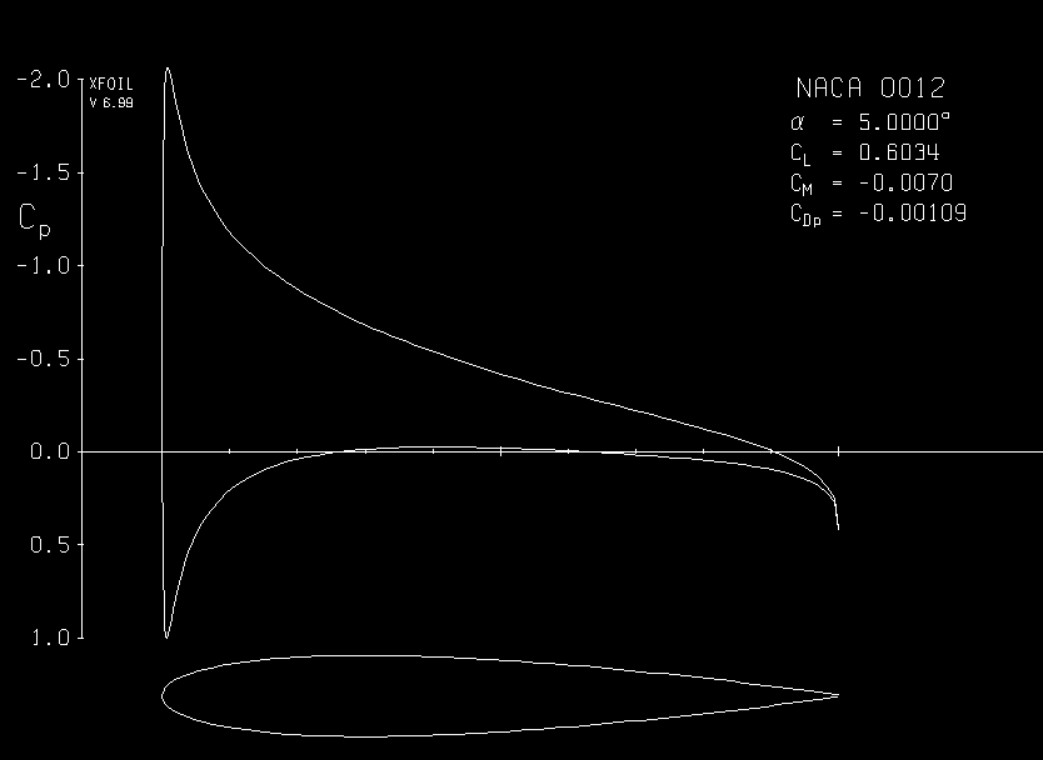

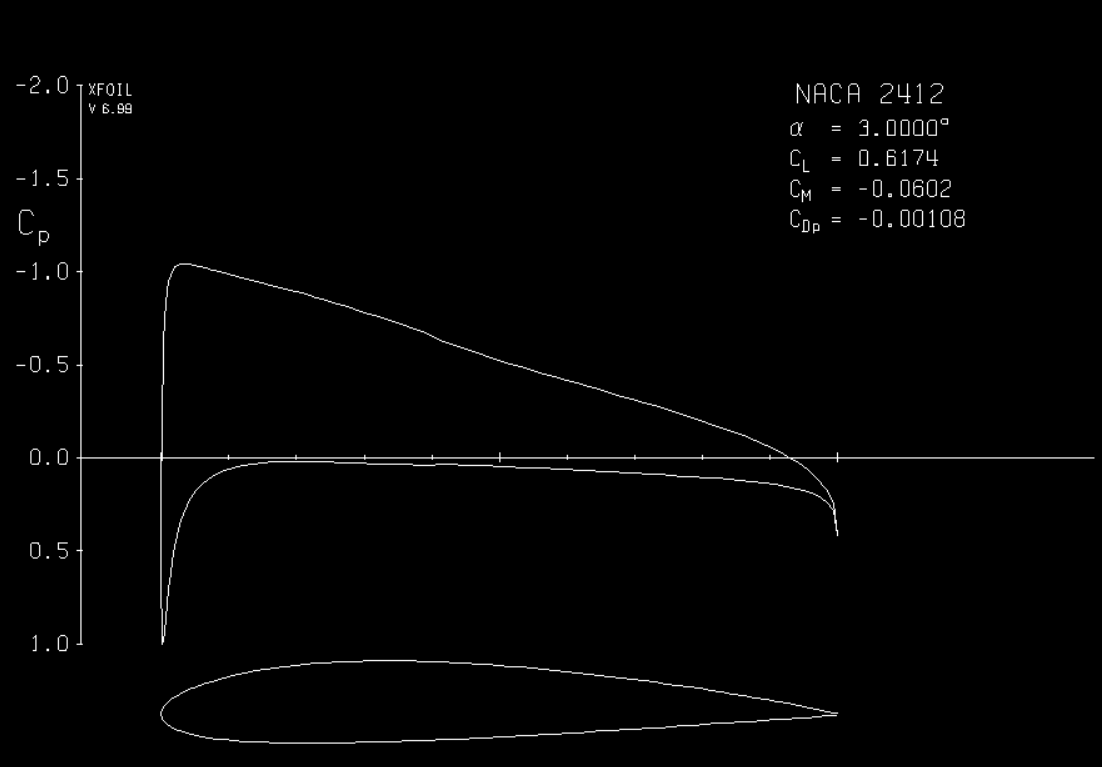

Which NACA 4-digit airfoil you want to study: 4412
At what angle of attack (in degrees): 10
How many points you want to divide vortex sheet into (eg: 100): 100
How many Fourier components you want to compare (eg: 10): 10


4412 is a cambered NACA 4-digit airfoil
List of fourier components, A0 to A10  [-0.009320711078221555, 0.16632427785174397, 0.02838628086848421, 0.008875970720848246, -0.003544991350486138, 0.0003642467094368959, 0.0016224591934828987, 0.005103106093451859, 0.0006864032389936048, 0.0022790505078979827, 0.00030943879071538465]
Sectional lift coefficient, cl: 1.5605820857456694
Sectional moment coefficient at quarter-chord point, cm(c/4): -0.10833624949337498



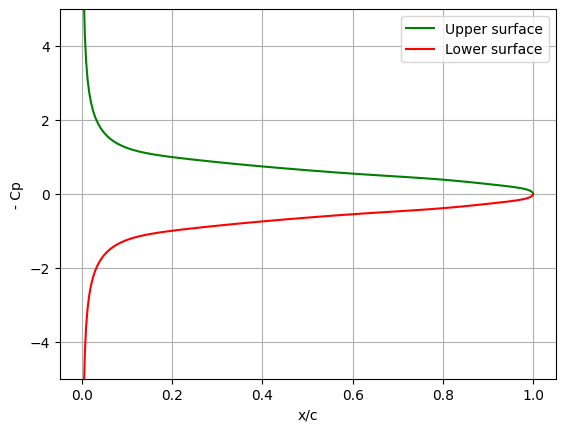

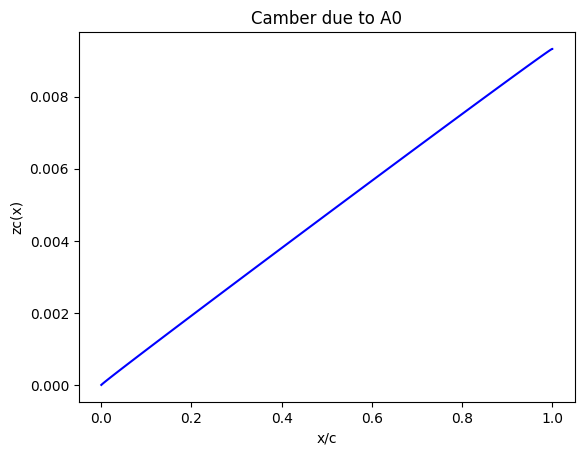

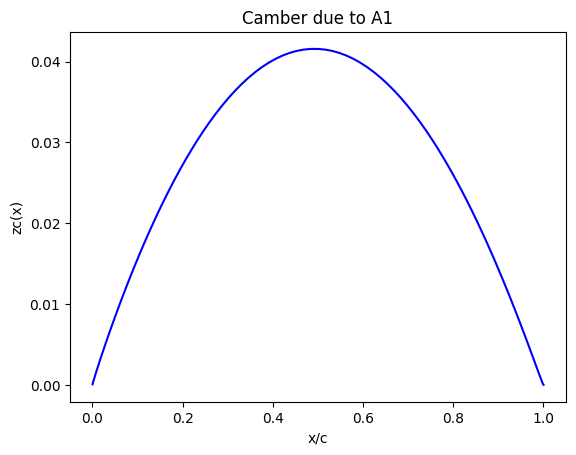

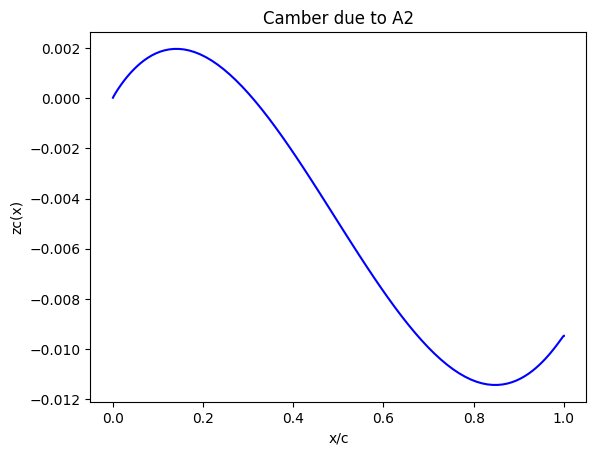

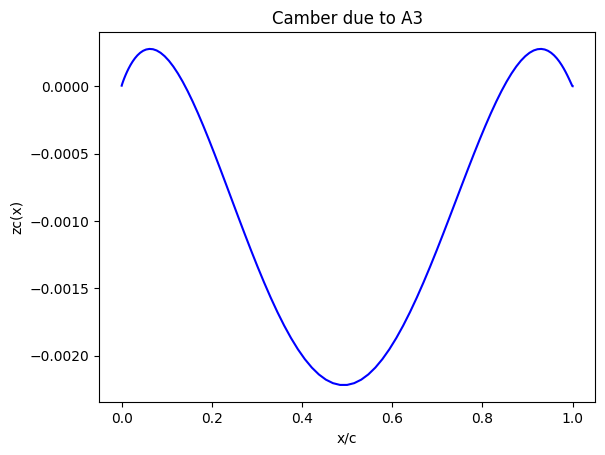

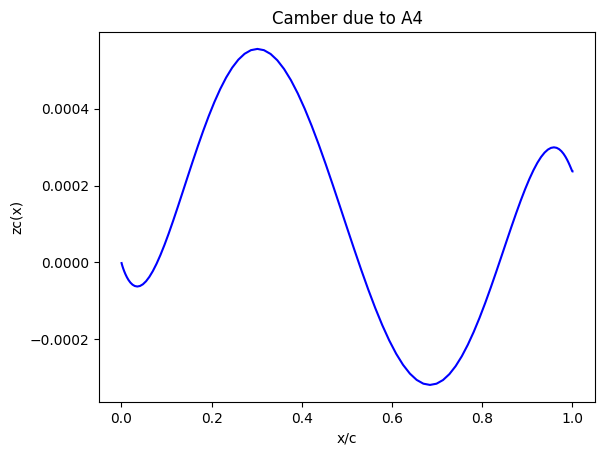

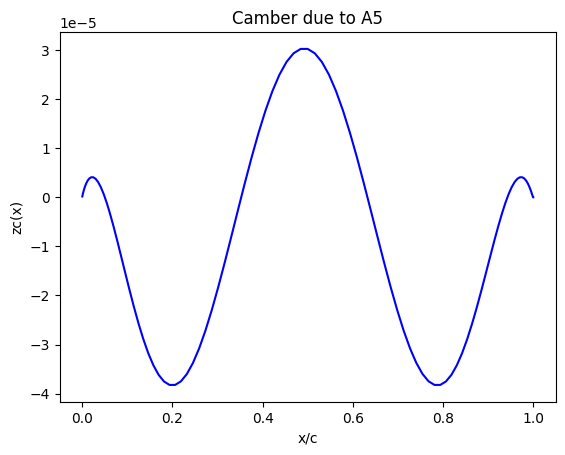

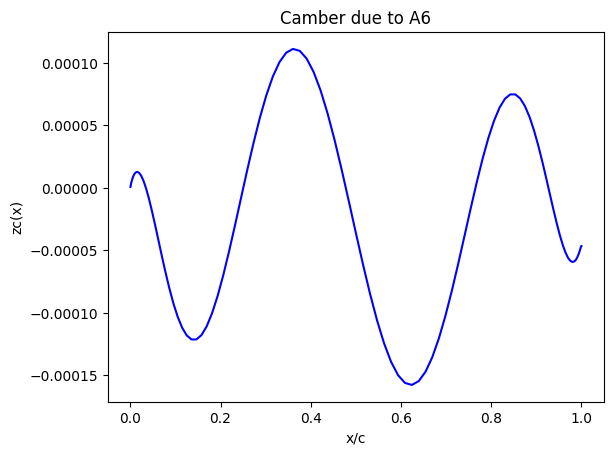

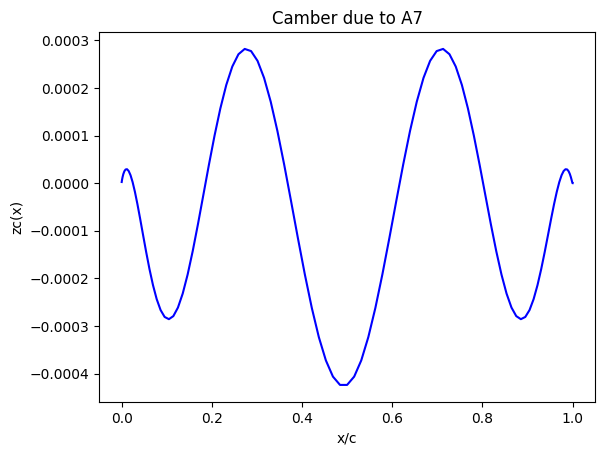

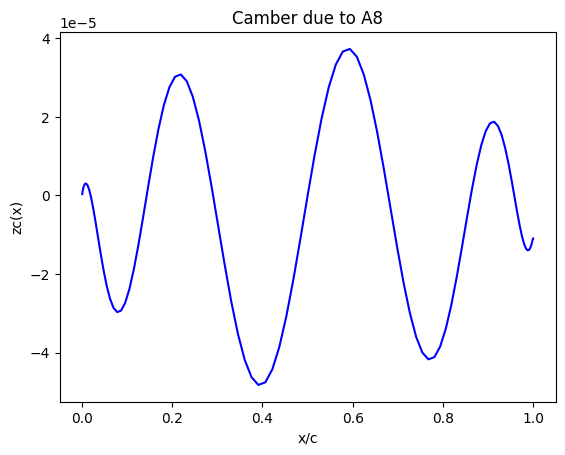

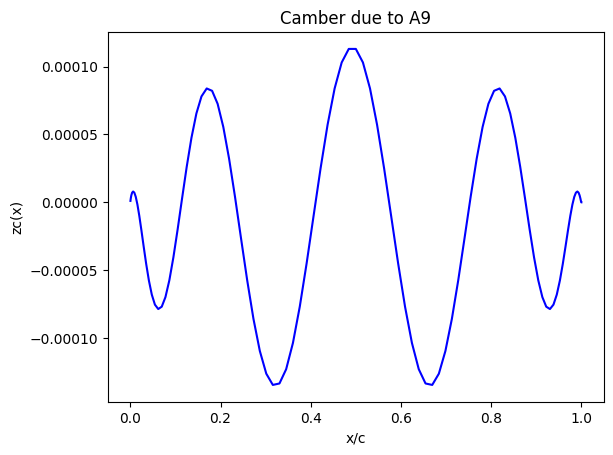

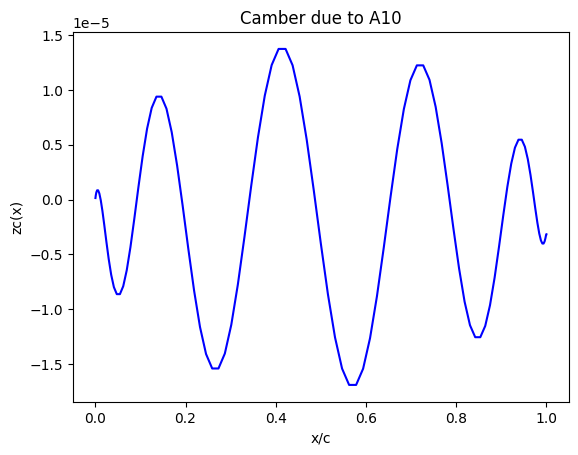

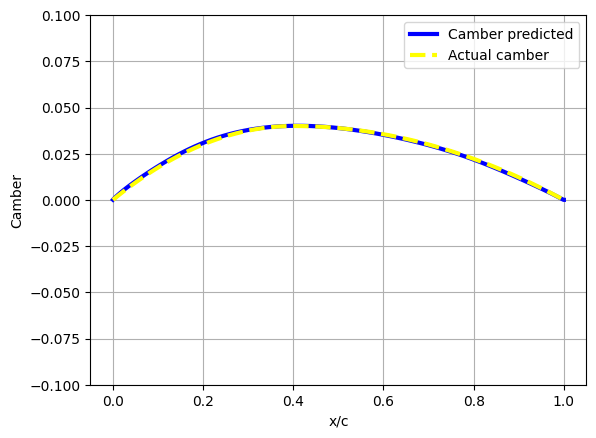




Enter x and y coordinates of window for streamlines visualization
x-coordinate of the lower-left corner of the visualization window: 0
y-coordinate of the lower-left corner of the visualization window: 0
x-coordinate of the upper-right corner of the visualization window: 3
y-coordinate of the upper-right corner of the visualization window: 3




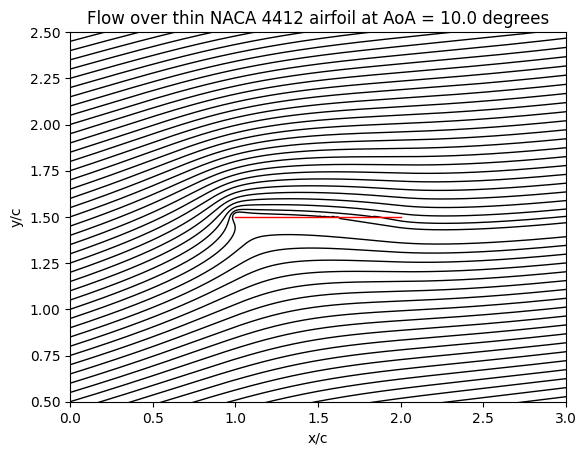

In [ ]:
""" Assumption: -> Freestream flow with velocity 1m/s is coming from left to right.
Class stream is created to draw streamlines arounf the chosen airfoil.
How? We will assume streamline is divided into some very small staright lines,
where the direction of these lines will give the velocity vector at the starting point
of the line. Therefore, some θ = tan-1(v/u) at that point will give us the slope of that line.
We will use this value of θ to get next x and y coordinate on the streamline and keep on building
the next points till some sufficient values of x and y in xy plane."""
class stream(object):
  def __init__(self, airfoil, alfa, nPts, nSrs):   # stream class' constrcutor will need 4 parameters where
  # first is expected to be some instance of airfoil class which will solve for the given airfoil the needed dz/dx,
  # gamma and other parameters. Second input will be angle of attack, third as number of points on vortex sheet, and final
  # fourth one as number of fourier components needed
    self.a1 = airfoil  # placing value of input instance of airfoil() class to self.a1 to access its parameters
    self.aoa = alfa*np.pi/180 # converting alpha to radians
    self.nPts = nPts # putting nPts as some variable self.nPts of stream class
    self.nSrs = nSrs # putting nSrs as some variable self.nSrs of stream class

  # inputs from user for window size of streamline plots
  def window(self):
    """As, our chord line is on x-axis of the coordinate axis but user may want to see it at some
    other place on the xy plane, so they can give the coordinates of the required window, and this fucntion
    will transfer chordline to the center of the window.
    This can help, if we have some other flow from some other solvers defined at that part of the window, so modifying
    this part of the chord can help us transfer the origin to some new point """
    print("Enter x and y coordinates of window for streamlines visualization")
    self.xi = float(input("x-coordinate of the lower-left corner of the visualization window: "))  # self explanatory input
    self.yi = float(input("y-coordinate of the lower-left corner of the visualization window: "))
    self.xf = float(input("x-coordinate of the upper-right corner of the visualization window: "))
    self.yf = float(input("y-coordinate of the upper-right corner of the visualization window: "))
    print("\n")
    self.newx_c = [] # list to store new values of x coordinates of points on chordline
    self.ycx = []    # list to store new values of x coordinates of camber curve
    oldzc_x = self.a1.zcx # taking original y coordinates of camber using airfoil class object
    self.y_c = []  # shifting y values of chordline to in new plane
    oldx_c = self.a1.x_c # taking original x coordinates of points on chordline
    for i in range(len(oldx_c)):
      self.newx_c.append(oldx_c[i] + (self.xi + self.xf)/2- 0.5)   # new x will be average of max. x and min. x of window - half the length of chord
      # which in our case is unit chord
      self.ycx.append((self.yi + self.yf)/2 + oldzc_x[i]) # new camber will be average of max. y and min. y of window plus original y of camber
    self.y_c = [(self.yi + self.yf)/2]*len(self.newx_c) # new chordlines' y value will be average of max. y and min. y of windows, and original y of
    # chordline was zero (chord on x-axis)
    return self.xi, self.yi, self.xf, self.yf, self.newx_c, self.y_c


  # func for generating one streamline which will be used for generating all
  # streamlines changing initial y-corrdinate
  """As described above, streamlineone(y_) will be used to plot one streamline starting at xi and yi.
  This function will be called by function stream() (defined below) with updated values of yi, which is set to increase by 0.05,
  initially. So, the upcming streamlines will start at xi, prev(y) + 0.05"""
  def streamlineone(self, y_):
    self.x, self.y = self.xi, y_ # start of streamline will be always at xi
    dels = 0.01
    self.l, self.r = [], []
    while self.x<=self.xf and self.y<=self.yf:
      self.l.append(self.x) # append starting value of x and y coordinates of given streamline
      self.r.append(self.y)
      #xs = self.newx_c[0]
      u = np.cos(self.aoa) # starting with contribution of freestream velocity in x and y direction as u and v, respectively,
      v = np.sin(self.aoa) # where aoa is angle of attack
      for i in range(len(self.newx_c)):
        dV = 0
        dist_2pi = 2*np.pi*abs(np.sqrt((self.x - self.newx_c[i])**2 + (self.y - self.y_c[i])**2)) # formula for magnitude of V at some
        # point x, y in space due to some vortex sheet with circulation density γ(s) centered at x(s) and y(s) is given above.
        # So, this is the denominator of same.
        if i != 0 and i != len(self.newx_c) - 1:
          """ values of γ(s) for the sheet is being fetched from results of airfoil class. ds is chosen such that the
          center of the vortex sheet is almost in the middle of the length dx. Here, estimated as the coordinate of next
          small vortex sheet - the coordinate of previous vortex sheet and divide this difference by 2"""
          dV = dV + (self.a1.gamma[i]*((self.newx_c[i+1] - self.newx_c[i])/2 + \
           (self.newx_c[i] - self.newx_c[i-1])/2))/dist_2pi
        else:
          """ finding dx in above way will  not be able to give dx for LE and TE, therefore multiplying it with some small dx = 0.01."""
          dV = dV + (self.a1.gamma[i]*(0.01))/dist_2pi
        distvec = np.arctan2((self.y - self.y_c[i]), (self.x - self.newx_c[i])) # finding the slope of vector joining x, y to x(s), y(s)
        u = u + dV*np.sin(distvec) # as velocity due to the vortex sheet is perpendicular to the r (distance) vector
        # therefore, dividing each component of velocity at x, y  point due to each sheet into two components in direction of x and y axis.
        # And then adding components of freestream velocity and iterating over all small sheets to calculate total u and v components at x, y.
        # After this we will use tan-1(v/u) at this point to get next point according to formula for x and y outside the loop or
        # as described above
        v = v + (-1)*dV*np.cos(distvec)
      self.x = self.x + dels*np.cos(np.arctan2(v,u)) # next point's x-coordinate
      self.y = self.y + dels*np.sin(np.arctan2(v,u)) # next point's y-coordinate
      self.l.append(self.x) # storing all these x
      self.r.append(self.y) # storing all these y
    plt.plot(self.l, self.r, linewidth = 1.0, color = 'black') # plotting each streamline in black
    return self.l, self.r

  def streamline(self): # this function as described will call stremalineone(y_) with updated value of y_, here
  # updating y by 0.05, until y_ reaches the yf given by user
    self.y_ = self.yi
    while self.y_ <= self.yf: # running loop till y_ reaches yf
        self.streamlineone(self.y_) # calling streamlineone() function for y_
        self.y_ = self.y_ + 0.05 # updating y_ for next iteration of loop
    plt.plot(self.newx_c, self.y_c, color = 'red', linewidth = 1.0) # plotting chordline if needed
    #plt.plot(self.newx_c, self.ycx, color = 'green', linewidth = 1.0) # remove # at start of this line 95 to plot camber
    plt.ylim((self.yi + self.yf)/2 - 1, (self.yi + self.yf)/2 + 1) # limiting the y coordinate to zoom in to the middle of window
    plt.xlim(self.xi, self.xf); plt.xlabel("x/c"); plt.ylabel("y/c")
    plt.title("Flow over thin NACA " + self.a1.str_foil + " airfoil" + " at AoA = " + str(self.aoa*180/np.pi) + " degrees")
    plt.show()

# driver routine
if __name__ == "__main__":
  solve_airfoil = airfoil() # airfoil class' constructor is being called and instance is named as solve_airfoil
  draw_streamlines = stream(solve_airfoil, solve_airfoil.alfa, solve_airfoil.nPts, solve_airfoil.nSrs) # calling stream class'
  # constrcutor with needed inputs; first input as an object of class airfoil()
  draw_streamlines.window() # object of stream() class calling its fucntion window() to define window for streamlines' visualization
  draw_streamlines.streamline() # calling function streamline() of stream() class to plot the streamlines